In [ ]:
!pip install tensorflow-gpu==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 95% 50.0M/52.6M [00:03<00:00, 23.6MB/s]
100% 52.6M/52.6M [00:03<00:00, 16.6MB/s]


In [ ]:
!unzip jigsaw-toxic-comment-classification-challenge.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf

### Data Exploration

In [ ]:
df = pd.read_csv('/content/train.csv.zip')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# checking for any null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Length of the comments

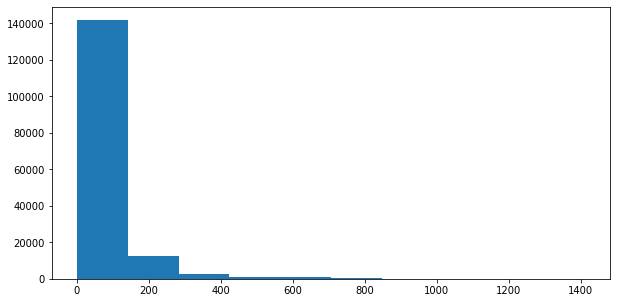

In [ ]:
comment_lengths = [len(comment.split()) for comment in df["comment_text"]]
plt.figure(figsize=(10,5))
plt.hist(comment_lengths);
plt.show()

### Distribution of Labels

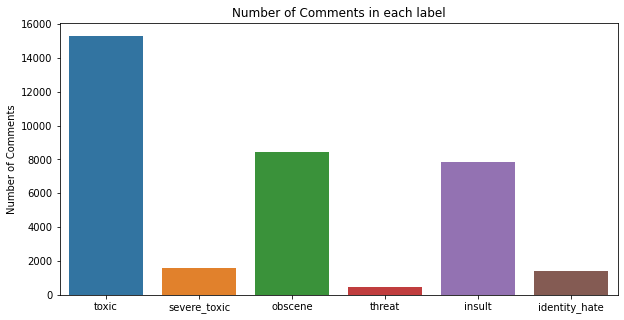

In [ ]:
# Number of tweets in each labels
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels_count = df[labels].sum()
plt.figure(figsize = (10,5))
sns.barplot(x = labels_count.index,y = labels_count.values);
plt.title("Number of Comments in each label");
plt.ylabel("Number of Comments");

In [ ]:
multilabel_count = df[labels].sum(axis = 1).value_counts()
multilabel_count

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

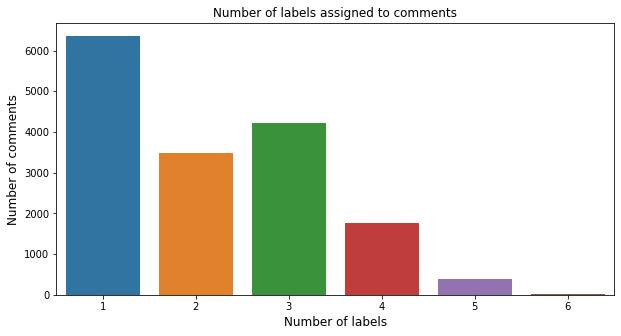

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x = multilabel_count.iloc[1:].index, y = multilabel_count.iloc[1:].values);
plt.title("Number of labels assigned to comments");
plt.xlabel("Number of labels", fontsize=12);
plt.ylabel("Number of comments",fontsize=12);

In [ ]:
# Number of tweets that does not have any label
print(f'Number of comments with no any labels(clean tweet): {multilabel_count.iloc[0]}')
print(f'Percentage of comments with no any labels: {round(multilabel_count.iloc[0]/len(df) * 100,3)}%')

Number of comments with no any labels(clean tweet): 143346
Percentage of comments with no any labels: 89.832%


### Data Processing

In [ ]:
# set aside 10% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(df, df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]], test_size = 0.10, random_state = 42)

In [ ]:
list_sentences_train = x_train["comment_text"]
list_sentences_test = x_test["comment_text"]

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

In [ ]:
# Number of unique words found
word_index = tokenizer.word_index
print(f'Number of unique words found: {len(word_index)}')

Number of unique words found: 197607


In [ ]:
# transform train and test data to tokens
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

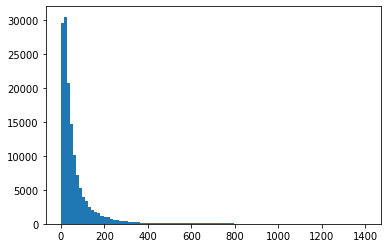

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords, bins = 100)
plt.show()

In [ ]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

### Build Model

In [ ]:
inp = Input(shape=(maxlen, ))

In [ ]:
embed_size = 128
x = Embedding(len(tokenizer.word_index), embed_size)(inp)

In [ ]:
x = GRU(60, return_sequences=True,name='gru_layer')(x)

In [ ]:
x = GlobalMaxPool1D()(x)

In [ ]:
x = Dropout(0.1)(x)

In [ ]:
x = Dense(50, activation="relu")(x)

In [ ]:
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=[tf.metrics.BinaryAccuracy(),tf.metrics.AUC(multi_label=True, name='auc')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          25293696  
                                                                 
 gru_layer (GRU)             (None, 200, 60)           34200     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [ ]:
batch_size = 32
epochs = 10

file_path="best_weights.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)

callbacks_list = [checkpoint, early] #early

hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.12, shuffle=True, callbacks=callbacks_list, verbose=1)

Epoch 1/10
3950/3950 [==============================] - ETA: 0s - loss: 0.0656 - binary_accuracy: 0.9784 - auc: 0.9358
Epoch 1: val_loss improved from inf to 0.05037, saving model to best_weights.h5
3950/3950 [==============================] - 178s 43ms/step - loss: 0.0656 - binary_accuracy: 0.9784 - auc: 0.9358 - val_loss: 0.0504 - val_binary_accuracy: 0.9814 - val_auc: 0.9595
Epoch 2/10
3950/3950 [==============================] - ETA: 0s - loss: 0.0435 - binary_accuracy: 0.9835 - auc: 0.9741
Epoch 2: val_loss improved from 0.05037 to 0.04638, saving model to best_weights.h5
3950/3950 [==============================] - 81s 21ms/step - loss: 0.0435 - binary_accuracy: 0.9835 - auc: 0.9741 - val_loss: 0.0464 - val_binary_accuracy: 0.9826 - val_auc: 0.9745
Epoch 3/10
3950/3950 [==============================] - ETA: 0s - loss: 0.0375 - binary_accuracy: 0.9854 - auc: 0.9819
Epoch 3: val_loss did not improve from 0.04638
3950/3950 [==============================] - 75s 19ms/step - loss: 0.

In [ ]:
def plot_model_history(model_history):
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    accuracy = model_history.history['binary_accuracy']
    val_accuracy = model_history.history['val_binary_accuracy']

    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    accuracy = model_history.history['auc']
    val_accuracy = model_history.history['val_auc']

    plt.plot(epochs, accuracy, label='Training AUC')
    plt.plot(epochs, val_accuracy, label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

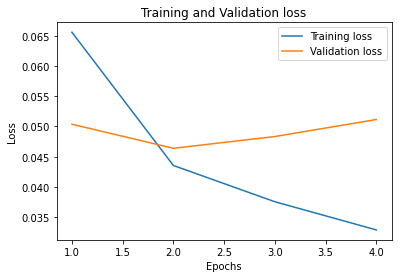

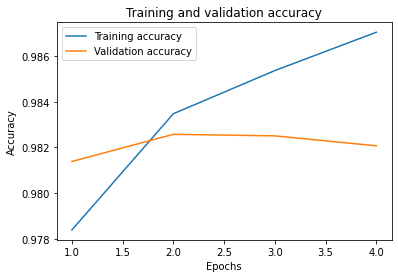

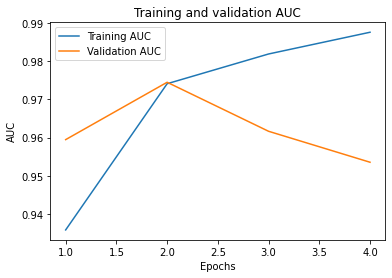

In [ ]:
plot_model_history(hist)

In [ ]:
model.load_weights(file_path)

In [ ]:
model.save('my_model')

In [ ]:
model.save('my_model.h5')

### Evaluate Model

In [ ]:
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f'Accuracy : {np.round(accuracy,4)}')
print(f'Auc : {np.round(auc,4)}')
print(f'Loss : {np.round(loss,4)}')

499/499 [==============================] - 3s 6ms/step - loss: 0.0441 - binary_accuracy: 0.9837 - auc: 0.9756
Accuracy : 0.9837
Auc : 0.9756
Loss : 0.0441


### Predict Comment

In [ ]:
comment = ["Fuck you bitch"]

In [ ]:
comment_tokenized = tokenizer.texts_to_sequences(comment)

In [ ]:
comment_train = pad_sequences(comment_tokenized, maxlen=maxlen)

In [ ]:
res = model.predict(comment_train)
res

1/1 [==============================] - 1s 770ms/step


array([[0.9999019 , 0.5171426 , 0.9968027 , 0.01146746, 0.9659564 ,
        0.07498632]], dtype=float32)

### Make Interface

In [ ]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
import gradio as gr

In [ ]:
def score_comment(comment):
    comment_tokenized = tokenizer.texts_to_sequences([comment])
    comment_train = pad_sequences(comment_tokenized, maxlen=maxlen)
    results = model.predict(comment_train)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://83b9a1492495ec79ed.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
